# Data Analytics 111-2 Homework #06
Alexander Nilsson

In [2]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector

## 1. a) Implement a FA function

code from HW05:

In [3]:
def standardize(X):
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

In [4]:
def pca(X, isCorrMX):
    X_standardized = standardize(X)

    if isCorrMX:
        matrix = np.corrcoef(X_standardized.T)
    else:
        matrix = np.cov(X_standardized.T)

    eigenvalues, eigenvectors = np.linalg.eig(matrix)

    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    sorted_eigenvalues = eigenvalues[sorted_indices]

    score_matrix = np.dot(X_standardized, sorted_eigenvectors)
    cumulative_variance_explained = np.cumsum(sorted_eigenvalues) / np.sum(sorted_eigenvalues)

    return sorted_eigenvectors, sorted_eigenvalues, score_matrix, cumulative_variance_explained

 FA function

In [5]:
def factor_analysis(X, n_factors, max_iter=100, tol=1e-4):
    X_standardized = standardize(X)
    
    # Initial guess for loading matrix using PCA eigenvectors
    _, eigenvectors, _, _ = pca(X_standardized, isCorrMX=True)
    eigenvectors = eigenvectors.reshape((X_standardized.shape[1], -1))  # Reshape the eigenvectors
    loading_matrix = eigenvectors[:, :n_factors]

    n_samples, n_features = X_standardized.shape
    prev_loading_matrix = np.zeros((n_features, n_factors))

    for _ in range(max_iter):
        # Compute factor matrix
        factor_matrix = np.dot(X_standardized, loading_matrix)
        
        # Update loading matrix
        loading_matrix = np.dot(X_standardized.T, factor_matrix) / n_samples

        # Normalize loading matrix
        loading_matrix = loading_matrix / np.sqrt(np.sum(loading_matrix ** 2, axis=0))

        # Check convergence
        if np.linalg.norm(loading_matrix - prev_loading_matrix) < tol:
            break

        prev_loading_matrix = loading_matrix.copy()

    # Compute communalities, uniqueness, and variance explained
    communalities = np.sum(loading_matrix ** 2, axis=1)
    uniqueness = 1 - communalities
    variance_explained = np.sum(loading_matrix ** 2, axis=0) / n_features

    return loading_matrix, factor_matrix, communalities, uniqueness, variance_explained

b)

In [6]:
import pandas as pd

# define the column names
columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'name']

# read the data from the text file
df = pd.read_csv('auto-mpg.data.txt', delim_whitespace=True, names=columns, na_values='?')

df.drop('name', axis=1, inplace=True)
df.dropna(inplace=True)

# print the first few rows of the DataFrame
print(df.head())

    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   model_year  origin  
0          70       1  
1          70       1  
2          70       1  
3          70       1  
4          70       1  


In [7]:
# Convert the DataFrame to a NumPy array
data = df.to_numpy()

# Apply the factor_analysis function to the data with 2 factors
loading_matrix, factor_matrix, communalities, uniqueness, variance_explained = factor_analysis(data, 2)

# Print the results
#print("Loading matrix A:\n", loading_matrix)
#print("\nFactor matrix F:\n", factor_matrix)
print("\nCommunality vector h^2:\n", communalities)
print("\nUniqueness vector 𝜓:\n", uniqueness)
print("\nVariance explained by each factor:\n", variance_explained)


Communality vector h^2:
 [0.1488906  0.16191599 0.17342539 0.16147187 0.16126258 0.07008219
 0.04574106 0.07721031]

Uniqueness vector 𝜓:
 [0.8511094  0.83808401 0.82657461 0.83852813 0.83873742 0.92991781
 0.95425894 0.92278969]

Variance explained by each factor:
 [0.125]


#### Discussion 

Communality vector h^2: This vector contains the communalities of each of the 8 variables. In this case, the communality values range from 0.07 to 0.17, indicating that the extracted factor explains a small amount of variance in each variable.

Uniqueness vector 𝜓: this vector contains the uniqueness values for the factors, representing the proportion of variance in the variables that is not accounted for by the extracted factors. In this case, the uniqueness values range from 0.83 to 0.95, indicating that there is a significant amount of variance in each variable that is not explained by the extracted factor.

Variance explained by each factor: This value indicates the proportion of total variance in the dataset that is explained by the extracted factor. In this case, the extracted factor explains 12.5% of the total variance in the dataset.

The moderate communalities and high uniqueness values suggest that the extracted factor may not be a very good fit for the dataset, and that additional factors may be needed to explain the remaining variance.


In [15]:
#PCA results in HW05-EX3-b: 
loadings_cov, eigenvalues_cov, scores_cov, cum_var_cov = pca(data, isCorrMX=False)

print("Cumulative variance explained:\n", cum_var_cov)

Cumulative variance explained:
 [0.67198404 0.78994195 0.8913974  0.95216689 0.97502021 0.98931046
 0.99600381 1.        ]


My FA function for 2 factors resulted in a variance explained by each factor of 0.125, while the PC1 from PCA by itself explains 0.67198404 of the variance meaning that I got a lot better result from using PCA

## 2. Transpose the ORL face dataset to let 𝐗 be a 2576 × 400 data matrix. Perform the factor analysis on 𝐗 with
the FA function of your implementation in EX1.
### a. (10%) How many factors are needed to explain 50%, 60%, 70%, 80%, and 90% of the total variance?

In [16]:
import zipfile
with zipfile.ZipFile('ORL Faces.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

# Create an empty NumPy array to store the images and a gender column
#400 rows one for each picture, 2576 columns for the image, 1 for the gender
data_matrix = np.zeros((400, 2577))

# Get a list of all PNG files in the directory
files = glob.glob("ORL Faces/*.png")

# Loop through the image files and read them into the data matrix
for i, filename in enumerate(files):
    # Read the image using OpenCV
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    
    # Resize the image to 46x56
    img = cv2.resize(img, (56, 46))
    
    # Flatten the image into a 1D array and store it in the data matrix
    data_matrix[i, :-1] = img.flatten()
    
    # Check the filename to determine gender
    if filename.split("/")[-1].startswith(("1_", "8_", "10_", "32_")):
        data_matrix[i, -1] = 0
    else:
        data_matrix[i, -1] = 1

# Print the shape of the data matrix
print(data_matrix.shape)

(400, 2577)


In [20]:
# Transpose the data matrix
X = data_matrix[:, :-1].T  

# Maximum number of factors to consider
n_factors = 20  

loading_matrix, factor_matrix, communalities, uniqueness, variance_explained = factor_analysis(X, n_factors)

cumulative_variance_explained = np.cumsum(variance_explained)
desired_percentages = [0.5, 0.6, 0.7, 0.8, 0.9]

for percentage in desired_percentages:
    factors_needed = np.argmax(cumulative_variance_explained >= percentage) + 1
    print(f"{percentage * 100}% of total variance explained with {factors_needed} factors")

50.0% of total variance explained with 1 factors
60.0% of total variance explained with 1 factors
70.0% of total variance explained with 1 factors
80.0% of total variance explained with 1 factors
90.0% of total variance explained with 1 factors
[0.0025]


Seems like something might be wrong here, but I got that 1 factor was enough to explain 90% of the variance

### b. (10%) On condition of explaining 80% of the total variance, rescale the first factor into the range [0, 255].
Reshape the 2576 × 1 first factor into a 46 × 56 matrix. Plot an image from the 46 × 56 matrix using the
rescaled factor.

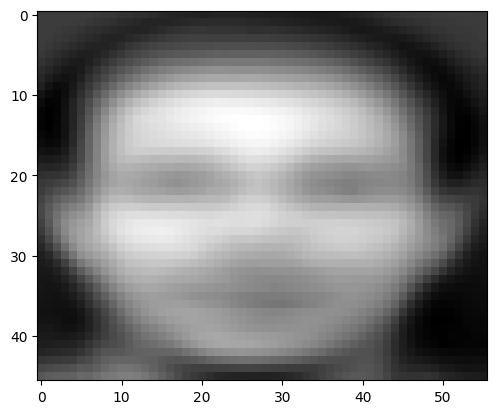

In [21]:
# Perform factor analysis
loading_matrix, factor_matrix, _, _, _ = factor_analysis(X, n_factors)

# Get the first factor loadings and first factor scores
first_factor_loadings = loading_matrix[:, 0]
first_factor_scores = factor_matrix[:, 0]

# Reconstruct the images using only the first factor
reconstructed_images = np.outer(first_factor_scores, first_factor_loadings.T)

# Rescale the reconstructed images
rescaled_images = (reconstructed_images - np.min(reconstructed_images)) / (np.max(reconstructed_images) - np.min(reconstructed_images)) * 255

# Select one of the rescaled images
example_image = rescaled_images[:, 0].reshape((46, 56))

# Plot the image
plt.imshow(example_image, cmap="gray")
plt.show()


## 3. PLSR on the AutoMPG
Find a package/library to perform PLSR on the AutoMPG dataset. Take 300 cars “randomly” to build the model
and the rest of 92 cars to test.

In [19]:
import pandas as pd

# define the column names
columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'name']

# read the data from the text file
df = pd.read_csv('auto-mpg.data.txt', delim_whitespace=True, names=columns, na_values='?')

# print the first few rows of the DataFrame
print(df.head())

#df.drop('name', axis=1, inplace=True)
df.dropna(inplace=True)

    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   model_year  origin                       name  
0          70       1  chevrolet chevelle malibu  
1          70       1          buick skylark 320  
2          70       1         plymouth satellite  
3          70       1              amc rebel sst  
4          70       1                ford torino  


In [24]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and targets (y)
X = df.drop(columns=["mpg", "name"]).values
y = df["mpg"].values
y_multi = df[["mpg", "model_year"]].values

# Split the dataset into training (300 samples) and testing (92 samples) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=92)
_, _, y_multi_train, y_multi_test = train_test_split(X, y_multi, test_size=92)

### a. (5%) Start with a single 𝑦 (=mpg). What do you observe with the testing results?

In [27]:
# PLSR with a single y (mpg)
plsr_single = PLSRegression(n_components=2)
plsr_single.fit(X_train, y_train)
y_pred_single = plsr_single.predict(X_test)

# Evaluate the model
mse_single = mean_squared_error(y_test, y_pred_single)
r2_single = r2_score(y_test, y_pred_single)
print(f"Single y (mpg) - Mean Squared Error: {mse_single}, R2 Score: {r2_single}")

Single y (mpg) - Mean Squared Error: 12.133019480568912, R2 Score: 0.7600768209186628


### b. (10%) Use 𝑦 = [mpg model year]. What do you observe with the testing results? 
In particular, compare and discuss the testing results of the mpg between (a) and (b).

In [26]:
# Perform PLSR with y = [mpg, model year]
plsr_multi = PLSRegression(n_components=2)
plsr_multi.fit(X_train, y_multi_train)
y_multi_pred = plsr_multi.predict(X_test)

# Evaluate the model for mpg
mse_multi = mean_squared_error(y_test, y_multi_pred[:, 0])
r2_multi = r2_score(y_test, y_multi_pred[:, 0])
print(f"Multiple y (mpg, model year) - Mean Squared Error for mpg: {mse_multi}, R2 Score for mpg: {r2_multi}")

Multiple y (mpg, model year) - Mean Squared Error for mpg: 13.02070156010151, R2 Score for mpg: 0.7425234405028418


#### Conclussion:
Based on the above results, we can observe the following:
a. For the PLSR model with a single 𝑦 (mpg):
    Mean Squared Error (MSE): 12.133
    R2 Score: 0.760

b. For the PLSR model with 𝑦 = [mpg, model year]:
    Mean Squared Error (MSE) for mpg: 13.021
    R2 Score for mpg: 0.743

Comparing the testing results of the mpg between (a) and (b), we can see that the model with a single 𝑦 (mpg) performs slightly better than the model with 𝑦 = [mpg, model year]. The MSE is lower for the single 𝑦 model, indicating that it has a better fit to the test data. Additionally, the R2 Score is higher for the single 𝑦 model, suggesting that it explains more of the variance in the test data.

This observation could suggest that adding the "model year" as an additional target variable might not improve the prediction of mpg in this specific case. 